# Minimal spiking model

## Dynamics

We start with a minimal spiking model. Each neuron sums its inputs over 1 timestep, which consist of upstream spikes, weighted by synaptic strengths, and external current injection:

$v^i(t) = \sum_j w^{ij} s^j(t-1) + I^i(t)$

If the sum exceeds a threshold $\theta^i$, the neuron spikes:

$v^i(t) \geq \theta^i \implies s^i(t) = 1$; otherwise $s^i(t) = 0$.

While we don't include inhibition in this model, we approximate one of its important roles by ensuring no more than $N_{max}$ spikes occur at any timestep. If more than $N_{max}$ spikes occur, we only let the neurons with the $N_{max}$ highest inputs spike and silence the rest.

Finally, to prevent the network from getting locked in a particular state, we impose a threshold-adaptation dynamic:

$\theta^i(t) = \theta^i(t-1) - \cfrac{1}{\tau_{\theta}}(\theta^i(t-1) - \theta^*) + a_\theta s(t-1)$.

This causes the spike-threshold to increase after spiking, which should prevent a given neuron from spiking during too many consecutive timesteps.

## Parameters

$N$: network size.

$N^*$: number of simultaneous spikes triggering full activation of weak network absent inhibition. Ie if $N^*$ neurons spike at once in a weak network, there should be a 0.5 chance that more than $N^*$ will spike at next time step.

$M$: ensemble size.

$M^*$: number of simultaneous spikes w/in ensemble to trigger full activation of ensemble absent inhibition.

$N_{max}$: maximum number of spikes at one timestep.

$q$: connection probability.

$w_{max}$: intra-ensemble cxn weight.

$w_{min}$: non-intra-ensemble cxn weight.

$\theta$: baseline spike threshold.

$a_{\theta}$: post-spike spike-threshold increase.

$\tau_{\theta}$: threshold-adaptation time constant.

## Parameter relationships

$\cfrac{M^*}{M} < \cfrac{N^*}{N}$ ie a maximally connected ensemble should require less relative triggering than the full network to activate. Thus, if the drive to the network increases uniformly, the ensemble should activate before the whole network.

How is $N^*$ related to $q$, $w_{min}$, and $\theta$? If $n(t)$ is the number of spikes in the network at $t$, we want 

$E[n(t+1)|n(t) = N^*] = N^*$.

For independent connection probabilities:

$p(n(t+1)|n(t)) = \textrm{Binomial}(n(t+1)|N, p(I \geq \theta|n(t)))$

so 

$E[n(t+1)|n(t)] = Np(I \geq \theta|n(t))$

so our criterion becomes

$Np(I \geq \theta|N^*) = N^*$.

Since all nonzero weights are equal and independent with existence probability $q$, for $I$ being an integer multiple of $w_{min}$ we have

$p(I|N^*) = \textrm{Binomial}(I/w_{min}|N^*, q)$ and $p(I \geq \theta|N^*) = \textrm{BiSvl}(\theta / w_{min}|N^*, q)$

where $\textrm{BiSvl}$ is the binomial survival function (total probability mass greater than a given value).

Therefore

$N\textrm{BiSvl}(\theta / w_{min}|N^*, q) = N^*$ 

or

$\textrm{BiSvl}(\theta / w_{min}|N^*, q) = \cfrac{N^*}{N}$

or

$N = \cfrac{N^*}{\textrm{BiSvl}(\theta / w_{min}|N^*, q)}$

Graphically, the relationship looks like:

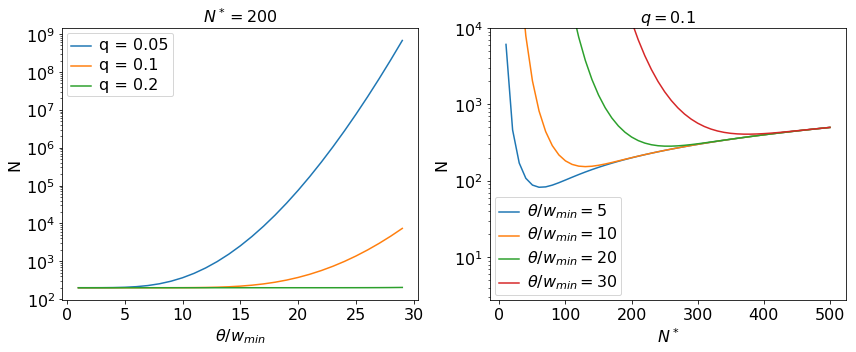

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from disp import set_font_size

bi_svl = stats.binom.sf

def calc_n(tht_w, n_s, q):
    return n_s / bi_svl(tht_w-.01, n_s, q)  # th_w offset to get greater-than-or-equal-to survival func

fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# th/w_min on x-axis, q as param
tht_w_min = np.arange(1, 30, dtype=int)
q = [.05, .1, .2]
n_s = 200

for q_ in q:
    axs[0].semilogy(tht_w_min, calc_n(tht_w_min, n_s, q_))
    
axs[0].set_xlabel(r'$\theta/w_{min}$')
axs[0].set_ylabel('N')
axs[0].set_title(r'$N^* = {}$'.format(n_s))
axs[0].legend(['q = {}'.format(q_) for q_ in q])

# N* on x-axis, q as param
n_s = np.round(np.linspace(10, 500, 50)).astype(int)
tht_w_min = [5, 10, 20, 30]
q = .1

for tht_w_min_ in tht_w_min:
    axs[1].semilogy(n_s, calc_n(tht_w_min_, n_s, q))

axs[1].set_ylim(top=1e4)
axs[1].set_xlabel(r'$N^*$')
axs[1].set_ylabel('N')
axs[1].set_title(r'$q = {}$'.format(q))
axs[1].legend([r'$\theta/w_{min} = ' + '{}$'.format(tht_w_min_) for tht_w_min_ in tht_w_min])
    
for ax in axs:
    set_font_size(ax, 16)

Since these results hold true for both the whole network as well as an individual ensemble (so long as we replace $N \rightarrow M$, $N^* \rightarrow M^*$, and $w_{min} \rightarrow w_{max}$, our requirement that $\cfrac{M^*}{M} < \cfrac{N^*}{N}$ is then equivalent to:

$\textrm{BiSvl}(\textrm{int}(\theta / w_{max})|M^*, q) < \textrm{BiSvl}(\textrm{int}(\theta / w_{min})|N^*, q)$

Letting $q = 0.1$, let's choose a reasonable $M$, $w_{max}$, $N$, and $w_{min}$.

Setting $M = 200$ and $w_{max} = \theta/3$, we see that $M^* \approx 17$.

In [2]:
print(calc_n(tht_w=4, n_s=17, q=.1))

205.70997015985796


Thus a 200 cell ensemble where each cell requires 4 simultaneous inputs to activate should require ~17 simultaneous spikes within the ensemble to activate, on average, so $M^*/M \approx 0.1$. For $N = 1000$, what do we need $w_{min}$ to be such that $\cfrac{M^*}{M} < \cfrac{N^*}{N}$? 

$w_{min} = \theta/50$ easily satisfies our requirement, since this requires $N^* \approx 496$ st $\cfrac{N^*}{N} \approx .5$.

In such a case, only 17 within ensemble neurons need to activate to trigger ensemble activation, whereas about 500 neurons need to spike to trigger full network activation (without inhibition). Thus, if a random 10% of the network spikes at time $t$, there is about a 50% chance the ensemble will activate but an extremely small chance the full network will activate. Thus, an embedded ensemble should be preferentially activated by global input to the network.

In [3]:
print(calc_n(tht_w=50, n_s=495, q=.1))
print(calc_n(tht_w=50, n_s=496, q=.1))

1006.0762839610094
996.0092608080473


Let's test this just to make sure.

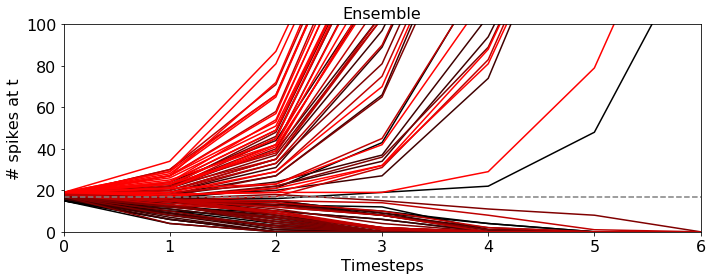

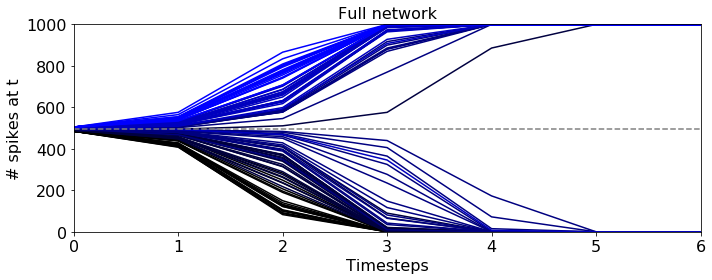

In [4]:
# ensemble
q = .1
tht = 1
m = 200
w_max = .26
t = np.arange(10)

colors = {15: (0, 0, 0), 16: (.25, 0, 0), 17: (.5, 0, 0), 18: (.75, 0, 0), 19: (1, 0, 0)}

np.random.seed(0)
cxn = np.random.rand(m, m) < q
w = np.zeros((m, m))
w[cxn] = w_max

fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

for n_spks_init in [15, 16, 17, 18, 19]:
    for seed in range(20):
        spks = np.zeros(m, dtype=bool)
        spks[np.random.permutation(m)[:n_spks_init]] = True
        
        n_spks = []
        
        for t_ in t:
            n_spks.append(spks.sum())
            spks = w.dot(spks) >= tht
            
        ax.plot(t, n_spks, color=colors[n_spks_init])

ax.axhline(17, color='gray', ls='--')
ax.set_xlim(0, 6)
ax.set_ylim(0, 100)
ax.set_xlabel('Timesteps')
ax.set_ylabel('# spikes at t')
ax.set_title('Ensemble')
set_font_size(ax, 16)

# full network
q = .1
tht = 1
n = 1000
w_max = .02001
t = np.arange(10)

colors = {485: (0, 0, 0), 490: (0, 0, .25), 495: (0, 0, .5), 500: (0, 0, .75), 505: (0, 0, 1)}

np.random.seed(0)
cxn = np.random.rand(n, n) < q
w = np.zeros((n, n))
w[cxn] = w_max

fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

for n_spks_init in [485, 490, 495, 500, 505]:
    for seed in range(20):
        spks = np.zeros(n, dtype=bool)
        spks[np.random.permutation(n)[:n_spks_init]] = True
        
        n_spks = []
        
        for t_ in t:
            n_spks.append(spks.sum())
            spks = w.dot(spks) >= tht
            
        ax.plot(t, n_spks, color=colors[n_spks_init])

ax.axhline(495, color='gray', ls='--')
ax.set_xlim(0, 6)
ax.set_ylim(0, 1000)
ax.set_xlabel('Timesteps')
ax.set_ylabel('# spikes at t')
ax.set_title('Full network')
set_font_size(ax, 16)

## Noise

We assume the network is driven with zero-mean Gaussian white noise, independent to each cell. Below we plot the fraction of neurons we expect to spike in response to noise alone, as a function of the noise STD. This is just the probability that a random noise input will be greater than $\theta = 1$.

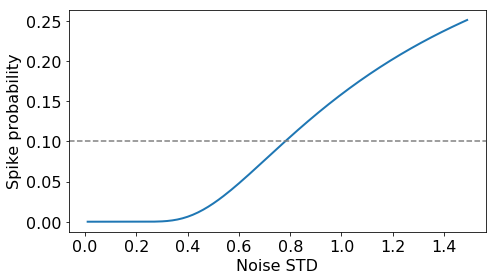

In [5]:
std = np.arange(.01, 1.5, .01)
p_spk = stats.norm.sf(1, 0, std)

fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)
ax.plot(std, p_spk, lw=2)
ax.axhline(.1, color='gray', ls='--')

ax.set_xlabel('Noise STD')
ax.set_ylabel('Spike probability')

set_font_size(ax, 16)

## Plasticity

We use the following spike-timing-dependent plasticity rule:

$
\Delta w_{ij}(\Delta t_{ij}) = \left\{
\begin{array}{ll}
    \alpha_- e^{-\Delta t_{ij} / \tau_-}(w_{ij} - w_{min}), & \quad  \Delta t_{ij} < 0 \\
    \alpha_+ e^{-\Delta t_{ij} / \tau_+}(w_{max} - w_{ij}), & \quad \Delta t_{ij} \geq 0 \\
\end{array}
\right.
$

where $\Delta t_{ij}$ is spike time in cell $j$ minus spike time in cell $i$ (ie causal = positive) and $-1 < \alpha_- < 0 < \alpha_+ < 1$. This rule is applied any time a spike in $i$ or $j$ occurs, and $w_{max}$ and $w_{min}$ keep the weights bounded.

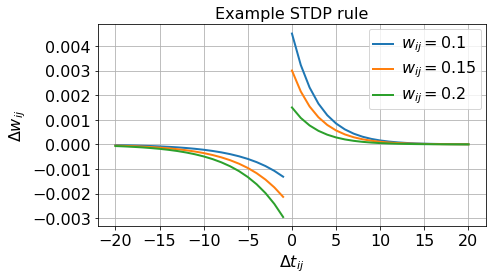

In [6]:
# example
w_min = .02
w_max = .25
w = [.1, .15, .2]
a_p = .03
a_m = -.02
t_p = 3
t_m = 5

d_t = np.array(list(range(-20, 0)) + [np.nan] + list(range(21)))

fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)

for w_ in w:
    
    d_w = np.nan * np.zeros(d_t.shape)
    d_w[d_t < 0] = a_m * np.exp(d_t[d_t < 0]/t_m) * (w_ - w_min)
    d_w[d_t >= 0] = a_p * np.exp(-d_t[d_t >= 0]/t_p) * (w_max - w_)
    
    ax.plot(d_t, d_w, lw=2)
    
ax.set_xlabel(r'$\Delta t_{ij}$')
ax.set_ylabel(r'$\Delta w_{ij}$')
ax.set_title('Example STDP rule')
ax.legend([r'$w_{ij} = ' + '{}$'.format(w_) for w_ in w])
ax.grid()

set_font_size(ax, 16)